In [4]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"  # 如果不需要，则修改为none即可。删除该段代码不起作用。

## 1. Extract Text From PDF - PyMuPDF

ignore_tables、页眉、页脚、侧边栏

In [1]:
import fitz  # 安装PyMuPDF，导入fitz

# 读取PDF文件内容并进行文本过滤 + 存储在一个字符串中
def extract_text_from_pdf(pdf_path):
    document = fitz.open(pdf_path)
    text = ""
    for page_num in range(len(document)):
        page = document.load_page(page_num)
        text += page.get_text()
    document.close()
    return text

pdf_path = "../test_paper2.pdf" # pdf_path = "../test_depression_pubmed13.pdf"
raw_text = extract_text_from_pdf(pdf_path)
raw_text

'Journal\n of\n Science\n and\n Medicine\n in\n Sport\n 17 (2014) 177–\n 182\nContents\n lists\n available\n at\n ScienceDirect\nJournal\n of\n Science\n and\n Medicine\n in\n Sport\nj\n our\n na\n l\n ho\n me\n page:\n www.elsevier.com/locate/jsams\nReview\nExercise\n and\n the\n treatment\n of\n depression:\n A\n review\n of\n the\n exercise\nprogram\n variables\nRobert\n Stanton a,∗,  Peter\n Reaburn b\na Central\n Queensland\n University,\n Institute\n for\n Health\n and\n Social\n Science,\n Centre\n for\n Mental\n Health\n Nursing\n Innovation,\n Rockhampton,\n Australia\nb School\n of\n Medical\n and\n Applied\n Sciences,\n Central\n Queensland\n University,\n Rockhampton,\n Australia\na  r\n t  i  c  l e  \ni n\n f\n o\nArticle\n history:\nReceived\n 3\n January\n 2013\nReceived\n in\n revised\n form\n 10\n March\n 2013\nAccepted\n 21\n March\n 2013\nAvailable online 18 April 2013\nKeywords:\nDepressive\n disorder\nClinical\n depression\nAerobic\n exercise\nRandomized\n control

In [53]:
from nltk.corpus import stopwords


# 加载 NLTK 的停用词
STOPWORDS = set(stopwords.words('english'))

# 添加自定义停用词 - 先处理大小写
# 定义不同类别的停用词
my_stopwords = {'et', 'al', 'week', 'weeks', 'weekly', 'journal'}
roman_numerals = {'i', 'ii', 'iii', 'iv', 'v', 'vi', 'vii', 'viii', 'ix', 'x',
                  'I', 'II', 'III', 'IV', 'V', 'VI', 'VII', 'VIII', 'IX', 'X',
                 }  # 将罗马数字转为集合
arabic_numerals = set(map(str, range(1, 11)))  # 1-10

# 合并所有停用词集合
custom_stopwords = my_stopwords.union(roman_numerals, arabic_numerals)

# 合并其他库的停用词 比如来自nltk或者sklearn
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
custom_stopwords = custom_stopwords.union(ENGLISH_STOP_WORDS)

# 最终的停用词集合
STOPWORDS = STOPWORDS.union(custom_stopwords)

def remove_stopwords(text):
    """Remove stopwords from a piece of text."""
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])


## 2. Data Cleaning

### remove_stopwords + custom

### remove in-text reference del_reference

In [54]:
def del_reference(text):
    # 使用正则表达式删除括号内的引用
    cleaned_text = re.sub(r'\([^)]*\)', '', text)
    return cleaned_text

### spacy deal_name

In [15]:
def deal_name(text):
    nlp = spacy.load('en_core_web_sm') # 加载英语模型 加载spaCy模型
    
    # non_person_keywords = [] 存储没有被识别为人名的关键词

    # # 对关键词列表中的每个关键词进行NER
    # for keyword in textrank_keywords_result:
    #     # 将关键词转换为一个spaCy文档对象
    #     doc = nlp(keyword)
    #     # 检查文档中是否有被识别为人名的实体
    #     if not any(ent.label_ == 'PERSON' for ent in doc.ents):
    #         non_person_keywords.append(keyword)

    # # non_person_keywords 现在包含了不包括人名的关键词
    # non_person_keywords[:10]

    # example = "John William and monroe • Harkness .... the United States." # monroe • Harkness无法识别
    doc = nlp(text) # 处理句子


    # 打印出不是人名的词 # 保持人名大写，小写无法识别
    # SpaCy 的命名实体识别（NER）功能来提取 'PERSON' 类型的实体。它遍历文档中的所有实体，仅保留标签为 'PERSON' 的实体，并将它们的文本内容存储在列表中。这意味着它只提取被明确标记为人名的实体，并且能够正确地处理较长的人名。
    result = ' '.join([ent.text for ent in doc.ents if ent.label_ != 'PERSON'])
    return result

### lower casing

df["text_lower"] = df["text"].str.lower()
df.head()

### deal web/www

In [ ]:
# **************************** 处理网址 否则www http org会被放在关键字前面几行 ****************************
def remove_urls(text): 
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

### deal hyphens

In [ ]:
# **************************** 处理连字符 ****************************
# 处理跨行的连字符（例如 distinc-
# tive 处理为 distinctive）
def deal_hyphen(text):
    return re.sub(r'(\w+)-\s(\w+)', r'\1\2', text)

### deal newline character \n

In [19]:
# **************************** 处理换行符：只删除\n符号，因为textrank是基于上下文的，不要去掉标点符号****************************
# 换行符替换为空格
# .strip() 去除开头和结尾的空格
def del_space(text):
    text1 = text.replace('\n', ' ').strip() 
    text2 = text1.replace(" .", ".")  # 替换句号前面的空格 "depressive episode ."
    text3 = re.sub(r'\s+', ' ', text2)  # 使用正则表达式替换多个连续空格为单个空格
    return text3

### remove reference

In [20]:
# **************************** 处理引用 ****************************
def del_reference(text):
    # 使用正则表达式删除括号内的引用
    cleaned_text = re.sub(r'\([^)]*\)', '', text)
    return cleaned_text

### filter numbers

In [18]:
# **************************** 过滤数字 ****************************
def remove_numbers(text):
    pattern = r'\d+'
    filtered_text = re.sub(pattern, '', text)
    return filtered_text

## 3. Extract Keywords

### gensim - TextRank - keywords

In [363]:
from gensim.summarization import keywords
import spacy


# **************************** textrank算法实现 - 调用keywords方法 ****************************
def extract_keywords_with_textrank(text, ratio=0.2, words=None, split=False, 
                                   scores=False, pos_filter=None,lemmatize=False, deacc=True):
    # 使用gensim的keywords提取
    result = keywords(text=text, ratio=ratio, words=words, split=split, scores=scores, 
                      pos_filter=pos_filter, lemmatize=lemmatize, deacc=deacc)
    return result

text1 = remove_urls(raw_text)
text2 = del_name(text1)

# 好像会把所有单词变小写，所以在这处理前先处理大写的人名，否则spacy无法处理小写人名
textrank_keywords_result = extract_keywords_with_textrank(text1, words=30, split=True,scores=False,lemmatize=True) 
textrank_keywords_result

# 无需对copyright、p、连字符、\n等额外处理
# lemmatize: 决定是否应用词形还原。词形还原是将单词还原到基本形态或词根的过程。例如，“running”变为“run”。
# scores相同会全部输出 算做一个
 # ('depression', 0.3569175294181351),
 # ('depressed', 0.3569175294181351),
 # ('depress', 0.3569175294181351),
 # ('depressions', 0.3569175294181351),


['exercised',
 'study',
 'clinically depressed',
 'reviewed',
 'interventional',
 'effects',
 'intensities',
 'trained',
 'health',
 'durations',
 'recommending',
 'programming',
 'individuals',
 'includes',
 'groups',
 'variability',
 'week',
 'med',
 'trial',
 'sports',
 'dose',
 'supervised',
 'report',
 'disord',
 'mins',
 'aerobic',
 'treatments',
 'populations',
 'therapy']

### TF-IDF - keyword

In [75]:
from sklearn.feature_extraction.text import TfidfVectorizer # pip install scikit-learn
import re
import spacy # !python -m spacy download en_core_web_sm
# from collections.abc import Mapping
import string


# 如果text是这种形式 已经分割成多个文档的列表，可以直接传入 
# documents = [
#     "这是第一篇文档的内容。",
#     "这是第二篇文档的内容。",
#     "这是第三篇文档的内容。",
#     # 在此添加更多文档
# ]

# 如果是字符串形式，需要[]这样传入

text = raw_text
text = del_space(text)
text = remove_urls(text)
text = deal_hyphen(text)
text = deal_name(text)
text = del_reference(text)
text = remove_stopwords(text)
text = remove_numbers(text)


from sklearn.feature_extraction.text import TfidfVectorizer

import numpy as np
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize


# 假设你的长文本存储在一个字符串变量中

# 将长文本放入列表中
documents = [text]

# 初始化一个TfidfVectorizer
vectorizer = TfidfVectorizer()

# 对文本进行向量化并转换成稀疏矩阵 使用TF-IDF向量化器拟合和转换文本数据转换文本为TF-IDF表示
X = vectorizer.fit_transform(documents)

# 获取特征名（单词） 获取提取的关键词列表 获取特征词汇
feature_names = vectorizer.get_feature_names_out()

import numpy as np

# 将文档的tf-idf向量转换成数组
tf_idf_array = X.toarray()[0]

# 获取排序的tf-idf索引
sorted_indices = np.argsort(tf_idf_array).tolist()

# 获取具有最高tf-idf值的词
top_n = 50  # 假设你想提取前10个关键词
top_n_indices = sorted_indices[-top_n:]

# 提取对应的关键词
TF_IDF_keywords = [feature_names[j] for j in reversed(top_n_indices)]

# 打印结果
print(f"Top {top_n} keywords: {TF_IDF_keywords}")


Top 50 keywords: ['perraton', 'science', 'journal', 'medicine', 'health', 'reaburn', 'pedro', 'colleagues', 'med', 'institute', 'treadmill', 'sports', 'dsm', 'nr', 'clin', 'cochrane', 'iv', 'clinical', 'table', 'psychiatry', 'years', 'two', 'singh', 'rockhampton', 'consecutive', 'national', 'elsevier', 'exercise', 'university', 'ltd', 'three', 'march', 'review', 'australia', 'public', 'central', 'queensland', 'qualiﬁed', 'days', 'depression', 'english', 'dw', 'yoga', 'eur', 'evidence', 'excellence', 'exerc', 'five', 'fj', 'ge']


### LDA - keyword

In [ ]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re

text=raw_text

text = remove_stopwords(text)


# 清理和分词
# 使用正则表达式去除标点符号和数字
text = re.sub(r'[\d\W]+', ' ', text)
tokens = word_tokenize(text.lower()) # 分词 tokens = word_tokenize(text)

# 去除停用词并进行词形还原
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer() # # 词干提取
tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words and len(word) > 1]  # 去除单个字符




from gensim import corpora, models # 最新版的4.3.2就可以用gensim

# 创建字典
dictionary = corpora.Dictionary([tokens])

# 创建文档-词汇矩阵
corpus = [dictionary.doc2bow(token) for token in [tokens]]
# 设置主题数
num_topics = 3

# 创建并训练LDA模型
lda_model = models.LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=10)

# 打印主题
topics = lda_model.print_topics(num_words=5)
for topic in topics:
    print(topic)




#### 整理输出
# 创建一个空列表用于存储结果
topics_list = []

# LDA模型中的topics是上面提到的topics变量
for topic_num, topic in lda.show_topics(num_topics=num_topics, formatted=False):
    topic_keywords = [(word, weight) for word, weight in topic]
    topics_list.append((topic_num, topic_keywords))

# 打印结果
for topic_num, topic_keywords in topics_list:
    print(f"主题 {topic_num}:")
    for word, weight in topic_keywords:
        print(f"    {word}: {weight}")


# 创建一个空列表用于存储所有关键词
keywords_list = []

# LDA模型中的topics是上面提到的topics变量
for topic_num, topic in lda.show_topics(num_topics=num_topics, formatted=False):
    for word, weight in topic:
        # 只添加关键词到列表
        keywords_list.append(word)

# 如果需要去重，可以将列表转换成集合再转回列表
keywords_list = list(set(keywords_list))

# 打印结果
print(keywords_list)


In [45]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

# 准备要显示的数据
vis_data = gensimvis.prepare(lda_model, corpus, dictionary)

# 显示主题模型的可视化
pyLDAvis.display(vis_data)


### BERT - keyword

In [1]:
# 使用BERT进行关键词提取：
# 使用BERT进行关键词提取通常需要使用预训练的BERT模型和相应的库来进行微调和处理。以下是一个使用Hugging Face Transformers库的示例代码：

In [43]:
from transformers import BertTokenizer, BertForMaskedLM
import torch

# 加载预训练的BERT模型和分词器
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForMaskedLM.from_pretrained(model_name)

# 载入你的PDF文本，假设存储在变量pdf_text中
pdf_text = raw_text

# 对文本进行分词和编码
input_text = "[CLS] " + pdf_text + " [SEP]"  # 添加CLS和SEP标记
input_ids = tokenizer.encode(input_text, add_special_tokens=False, return_tensors='pt')

# 设置要提取的关键词数量
num_keywords = 15

# 初始化一个空的关键词列表
keywords = []

# 遍历文本中的每个词语
for token_id in input_ids[0]:
    token = tokenizer.decode(token_id.item())  # 将token_id解码成文本
    masked_text = input_text.replace(tokenizer.mask_token, token)  # 替换[MASK]标记为当前词语
    masked_input = tokenizer.encode(masked_text, add_special_tokens=False, return_tensors='pt')  # 重新编码带有替换词语的文本
    with torch.no_grad():
        outputs = model(masked_input)
        predictions = outputs.logits
    
    # 获取当前词语的预测分数
    token_index = masked_input[0].tolist().index(tokenizer.mask_token_id)
    token_score = predictions[0, token_index, :].numpy()
    
    # 使用平均分数作为关键词的重要性分数
    keyword_score = token_score.mean()
    
    # 将关键词和其分数添加到列表中
    keywords.append((token, keyword_score))

# 按关键词分数降序排序
keywords.sort(key=lambda x: x[1], reverse=True)

# 提取前num_keywords个关键词
top_keywords = [kw[0] for kw in keywords[:num_keywords]]

# 打印提取的关键词
for keyword in top_keywords:
    print(keyword)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Token indices sequence length is longer than the specified maximum sequence length for this model (8624 > 512). Running this sequence through the model will result in indexing errors


RuntimeError: The expanded size of the tensor (8624) must match the existing size (512) at non-singleton dimension 1.  Target sizes: [1, 8624].  Tensor sizes: [1, 512]

### BoW - keywords

In [9]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

# 示例文本
documents = [raw_text]

# 步骤1: 预处理文本（在这里我们使用CountVectorizer来简化预处理步骤）
vectorizer = CountVectorizer(stop_words='english')

# 步骤2和步骤3: 创建词汇表并向量化文本
word_count_vector = vectorizer.fit_transform(documents)

# 步骤4: 使用TF-IDF来确定文本中词的权重
tfidf_transformer = TfidfTransformer(smooth_idf=True, use_idf=True)
tfidf_transformer.fit(word_count_vector)
tf_idf_vector = tfidf_transformer.transform(word_count_vector)

# 获取关键字
feature_names = vectorizer.get_feature_names_out()
for doc_idx in range(len(documents)):
    doc_vector = tf_idf_vector[doc_idx]
    sorted_items = sorted(zip(feature_names, doc_vector.toarray().flatten()), key=lambda x: x[1], reverse=True)
    keywords = [item[0] for item in sorted_items[:15]]  # 提取前3个关键字
    print(f"Document {doc_idx + 1} Keywords: {keywords}")


Document 1 Keywords: ['exercise', 'depression', 'review', 'studies', 'intensity', 'aerobic', 'al', 'et', 'treatment', 'interventions', 'duration', 'group', 'program', 'min', 'intervention']


### keyword - wordcloud

<Figure size 500x500 with 0 Axes>

(-0.5, 499.5, 199.5, -0.5)

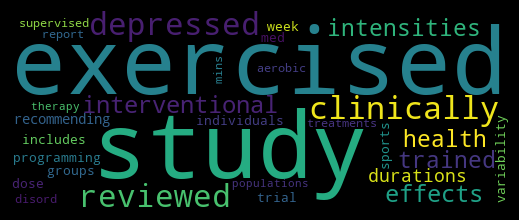

In [364]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

# list ->string
keywords = textrank_keywords_result[:30]
my_string = ' '.join(keywords[:30])

# summary 应该是一个字符串，包含了所有要显示在词云中的文本
# 创建 WordCloud 对象
wordcloud = WordCloud(
                width = 500, height = 200, 
                background_color ='black', 
                # stopwords = stopwords, 
                min_font_size = 10
            ).generate(my_string)  # <wordcloud.wordcloud.WordCloud at 0x1673575d0> 是一个对象


# 使用 matplotlib 显示词云
plt.figure(figsize = (5, 5), facecolor = 'k', edgecolor = 'k' )  # plt.figure(figsize=(75, 50), facecolor=None)
plt.imshow(wordcloud)  # plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.tight_layout(pad=0)

# 显示图形
plt.show()



In [162]:
# from matplotlib_venn import venn2 # !pip install matplotlib_venn
# def compare(gensim_keywords):
#     # 假设这是通过gensim和PyTextRank提取的关键词集合
#     # paper_keywords = set(
#     #     ['Depressive disorder', 'Clinical depression', 'Aerobic exercise', 'Randomized controlled trials',
#     #      'Exercise training'])
#     paper_keywords = set(
#     ['life stress', 'major depression', 'recurrence', 'recurrent depression', 'stress sensitization', 'dual pathway models'])
#     # pytextrank_kewords = set(
#     #     ['First episode major depression', 'Monroe et al', 'recurrent depression', 'many recurrences', 'et al',
#     #      'defining recurrences', 'recurrence predictors', 'recurrence risk', 'RECURRENCES', 'recurrence'])

#     # 创建Venn图
#     venn2([paper_keywords, gensim_keywords], ('Paper', 'gensim'))
#     plt.show()
# compare(set(keywords))

TypeError: 'function' object is not iterable

---

In [170]:
import pandas as pd


# 创建一个包含提取文本的DataFrame
df = pd.DataFrame({'text': [textrank_keywords_result]})

# 打印DataFrame的前几行
print(df.head())


                                                text
0  [recurrent, depressions, episode, disord, clin...


In [174]:
# 将列表转换为 DataFrame
df = pd.DataFrame(textrank_keywords_result, columns=['text'])
df.head()

,text
0,recurrent
1,depressions
2,episode
3,disord
4,clinically


In [169]:
# 拆分文本-dataframe： 如果文本非常长，可能会对内存造成压力，因此要确保你的计算机具有足够的内存来处理这个数据 - 考虑分割文本或其他来处理

import pandas as pd

splited_raw_text = raw_text.split('\n') # 将文本按换行符分割成多个段落


df = pd.DataFrame({'text': splited_raw_text}) # 创建一个包含多个段落的DataFrame


print(df) # 打印 DataFrame的内容


                                                   text
0     Annual Review of Clinical Psychology\nMajor De...
1                              University of Notre Dame
2                                            Notre Dame
3                                               Indiana
4      USA;\nemail: smonroe1@nd.edu\n2Department of ...
...                                                 ...
1100   and Affect in Depression: Insights from the T...
1101                                 Christiana Westlin
1102                                   Karen S. Quigley
1103                           Susan Whitfield-Gabrieli
1104  \nand Lisa Feldman Barrett p p p p p p p p p p...

[1105 rows x 1 columns]


In [175]:
import numpy as np
import pandas as pd
import re
import nltk
import spacy
import string
pd.options.mode.chained_assignment = None

In [176]:


def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)
# remove_urls(df[0])
# df.head()

df['text'] = df['text'].apply(remove_urls)
df["text"] = df["text"].str.lower()
df.head()

,text
0,recurrent
1,depressions
2,episode
3,disord
4,clinically


In [180]:
PUNCT_TO_REMOVE = string.punctuation

# 添加自定义的标点符号或字符 Add
custom_punctuations = '©•'
PUNCT_TO_REMOVE += custom_punctuations  # 将它们添加到标点字符串中

def remove_punctuation(text):
    """custom function to remove the punctuation"""
    return text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))



df["text"] = df["text"].apply(lambda text: remove_punctuation(text))
df.head()

,text
0,recurrent
1,depressions
2,episode
3,disord
4,clinically


In [184]:
STOPWORDS = set(stopwords.words('english'))

# 添加自定义停用词 Add
custom_stopwords = {'et al.', 'first', 'case', 'one','http','https'}  # 可以根据需要添加更多
STOPWORDS.update(custom_stopwords)
                 
def remove_stopwords(text):
    """custom function to remove the stopwords"""
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

df["text"] = df["text"].apply(lambda text: remove_stopwords(text))
df.head(15)

,text
0,recurrent
1,depressions
2,episode
3,disord
4,clinically
5,monroe
6,research
7,definiteness
8,studying
9,psychol


In [179]:
from collections import Counter
cnt = Counter()
for text in df["text"].values:
    for word in text.split():
        cnt[word] += 1
        
cnt.most_common(20)

[('recurrent', 1),
 ('depressions', 1),
 ('episode', 1),
 ('disord', 1),
 ('clinically', 1),
 ('monroe', 1),
 ('research', 1),
 ('definiteness', 1),
 ('studying', 1),
 ('psychol', 1),
 ('stressful', 1),
 ('psychiatry', 1),
 ('bases', 1),
 ('empirically', 1),
 ('following', 1),
 ('org', 1),
 ('majority', 1),
 ('http', 1),
 ('theory', 1),
 ('cases', 1)]

In [99]:
FREQWORDS = set([w for (w, wc) in cnt.most_common(10)])
def remove_freqwords(text):
    """custom function to remove the frequent words"""
    return " ".join([word for word in str(text).split() if word not in FREQWORDS])

df["text"] = df["text"].apply(lambda text: remove_freqwords(text))
df.head()

,text
0,annual review clinical psychology course matte...


In [186]:

n_rare_words = 10
RAREWORDS = set([w for (w, wc) in cnt.most_common()[:-n_rare_words-1:-1]])
def remove_rarewords(text):
    """custom function to remove the rare words"""
    return " ".join([word for word in str(text).split() if word not in RAREWORDS])

df["text"] = df["text"].apply(lambda text: remove_rarewords(text))
df.head()

,text
0,recurrent
1,depressions
2,episode
3,disord
4,clinically


In [187]:
from nltk.stem.porter import PorterStemmer



stemmer = PorterStemmer()
def stem_words(text):
    return " ".join([stemmer.stem(word) for word in text.split()])

df["text"] = df["text"].apply(lambda text: stem_words(text))
df.head()

,text
0,recurr
1,depress
2,episod
3,disord
4,clinic


In [188]:
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
def lemmatize_words(text):
    return " ".join([lemmatizer.lemmatize(word) for word in text.split()])

df["text"] = df["text"].apply(lambda text: lemmatize_words(text))
df.head()

,text
0,recurr
1,depress
2,episod
3,disord
4,clinic


In [194]:
def remove_html(text):
    html_pattern = re.compile('<.*?>')
    return html_pattern.sub(r'', text)

text = """<div>
<h1> H2O</h1>
<p> AutoML</p>
<a href="https://www.h2o.ai/products/h2o-driverless-ai/"> Driverless AI</a>
</div>"""

df['text'] = df['text'].apply(remove_urls)
df.head(20)

,text
0,recurr
1,depress
2,episod
3,disord
4,clinic
5,monro
6,research
7,definit
8,studi
9,psychol


In [191]:
text_str = df.to_string()
print(text_str)

                           text
0                        recurr
1                       depress
2                        episod
3                        disord
4                        clinic
5                         monro
6                      research
7                       definit
8                         studi
9                       psychol
10                       stress
11                   psychiatri
12                         base
13                        empir
14                       follow
15                          org
16                        major
17                             
18                       theori
19                         case
20                         rate
21                       differ
22                       provid
23                    psychiatr
24                         time
25                     recoveri
26                        gener
27                      theoret
28                    predictor
29                         life
30      

In [117]:



# 将每一行转换为字符串，并用空格分隔每个元素
rows_as_str = [' '.join(map(str, row)) for _, row in df.iterrows()]

# 将所有行的字符串用空格连接起来
result_str = ' '.join(rows_as_str)

print(result_str)


annual review clinic psycholog cour matter scott monroe1 kate l harkness2 1depart psycholog univ notr dame notr dame indiana usa email smonroe1ndedu 2depart psycholog queen’ univ kingston ontario canada annu rev clin psychol 2022 18329–57 publish review advanc februari 25 2022 annual review clinic psycholog onlin clinpsyannualreviewsorg 021440 copyright 2022 annual review right reserv keyword stress stress sensit dual pathway model abstract preval debilit person public health condit worldwid le appreci depr sion’ tremend burden share equal among becom depress suffer rest live wherea half never base two distinc tive cour prototyp propo subtyp distinct research origin lifetim cour press goal determin time depression’ onset follow clinic trajectori lack recognit distinct result mani obstacl includ conceptu bia methodolog oversight definit dead end current theori review compar implic contemporari diagnost controversi reevalu research treatment preventionand enhanc predict strength tradit w

## 4. Extract Abstract

In [3]:
!python --version

Python 3.11.5


In [365]:
!pip install transformers

In [30]:
import torch # !pip3 install torch torchvision torchaudio # pip-python2 pip3-python3

print(torch.__version__)
print(torch.cuda.is_available())  # 如果你有GPU并且安装了CUDA版本的PyTorch，这应该返回True


2.1.2
False


### T5Tokenizer - Abstract

In [31]:
from transformers import T5Tokenizer, T5ForConditionalGeneration 
# install sentencepiece SentencePiece是一个用于文本分词和解码的库，T5模型在处理文本时需要它。
# install --upgrade transformers
# 加载预训练的T5模型和分词器
tokenizer = T5Tokenizer.from_pretrained('t5-small')
model = T5ForConditionalGeneration.from_pretrained('t5-small')

# 对文本进行编码，并生成摘要
inputs = tokenizer.encode("summarize: " + raw_text, return_tensors="pt", max_length=512, truncation=True)
summary_ids = model.generate(inputs, max_length=150, min_length=40, length_penalty=2.0, num_beams=4, early_stopping=True)
t5_small_summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)

t5_small_summary


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


'Annual Review of Clinical Psychology Major depression and its Recurrences: Life Course Matters Scott M. Monroe1 and Kate L. Harkness2 1Department of Psychology, University of Notre Dame, Notre Dame, Indiana, USA. a subtype distinction for research on the origins and lifetime course of major depression.'

In [32]:
from transformers import T5Tokenizer, T5ForConditionalGeneration 
# install sentencepiece SentencePiece是一个用于文本分词和解码的库，T5模型在处理文本时需要它。
# install --upgrade transformers
# 加载预训练的T5模型和分词器
tokenizer = T5Tokenizer.from_pretrained('t5-large')
model = T5ForConditionalGeneration.from_pretrained('t5-large')

# 对文本进行编码，并生成摘要
inputs = tokenizer.encode("summarize: " + raw_text, return_tensors="pt", max_length=512, truncation=True)
summary_ids = model.generate(inputs, max_length=150, min_length=40, length_penalty=2.0, num_beams=4, early_stopping=True)
t5_large_summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)

t5_large_summary


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


"major depression's burdens are not shared equally among all who become depressed. some will suffer recurrences over the rest of their lives, whereas half or more will never have a recurrence. authors propose a subtype distinction for research on the origins and lifetime course of major depression."

### BartTokenizer - Abstract - bart-large-cnn

In [33]:
from transformers import BartForConditionalGeneration, BartTokenizer, BartConfig
tokenizer=BartTokenizer.from_pretrained('facebook/bart-large-cnn')
model=BartForConditionalGeneration.from_pretrained('facebook/bart-large-cnn')


    
raw_text = extract_text_from_pdf(pdf_path)
# raw_text

# Encoding the inputs and passing them to model.generate()
# inputs = tokenizer.batch_encode_plus([raw_text],return_tensors='pt') Token indices sequence length is longer than the specified maximum sequence length for this model (30551 > 1024). Running this sequence through the model will result in indexing errors
inputs = tokenizer.batch_encode_plus([raw_text], return_tensors='pt', max_length=1024, truncation=True)

summary_ids = model.generate(inputs['input_ids'], early_stopping=True)

# Decoding and printing the summary
bart_summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
print(bart_summary)

Annual Review of Clinical Psychology: Major Depression and Its Recurrences. Some will suffer recurrences over the rest of their lives, whereas half or more will never have a recurrence. Current theories are reviewed and compared. The implications for contemporary diagnostic controversies, reevaluating research on treatment and prevention,and enhancing the predictive strength are discussed.


In [45]:
type(bart_summary)

str

### gensim - Abstract - Result [v3.8 support]

In [ ]:
 ### gensim - Abstractimport gensim
from gensim.summarization import summarize  # !pip3 install gensim==3.8
import re
import spacy # !python -m spacy download en_core_web_sm
# from collections.abc import Mapping


# **************************** 处理网址 org edu http https等 ****************************
def remove_urls(text): 
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)



# **************************** 处理连字符 ****************************
# 处理跨行的连字符（例如 distinc-
# tive 处理为 distinctive）
def deal_hyphen(text):
    return re.sub(r'(\w+)-\s(\w+)', r'\1\2', text)

# **************************** 处理换行符：只删除\n符号，因为textrank是基于上下文的，不要去掉标点符号****************************
# 换行符替换为空格
# .strip() 去除开头和结尾的空格
def del_space(text):
    text1 = text.replace('\n', ' ').strip() 
    text2 = text1.replace(" .", ".")  # 替换句号前面的空格 "depressive episode ."
    text3 = re.sub(r'\s+', ' ', text2)  # 使用正则表达式替换多个连续空格为单个空格
    return text3



# **************************** 处理边界 ****************************
# 查找最近的句子边界：如果最后一个字符不是正确的标点符号，则从摘要结尾处向后查找最近的句号、问号或感叹号。这样可以确保您以一个完整的句子结尾。
def del_end(text):
        # Ensure Proper Ending
    if not text[-1] in ['.', '?', '!']:
        # Find Nearest Sentence Boundary
        end_position = max(text.rfind('.'), text.rfind('?'), text.rfind('!'))
        if end_position != -1:
            # Slice the Summary to the nearest sentence boundary
            text = text[:end_position + 1]
    
    # Step 3: Return the Processed Summary
    return text


summary = summarize(raw_text, ratio=0.05)  # 摘要占原文 1% 的长度
summary = deal_hyphen(summary)
summary = remove_urls(summary)
summary = del_reference(summary)
gensim_summary = del_space(summary)

# summary = del_end(summary)
gensim_summary


gensim_summaries="in the use of exercise trials have demonstrated in a number of systematic nature of the exercise on all RCTs reporting type, exercise type, exercise and quality of supervision Five RCTs published cross trainer Interfor the use supervised colleagues10 randomized co-workers5 reported 2013 Sports Medicine Australia. 2013 Sports Medicine Australia. colleagues15 reviewed volume16 programs. meta-analysis17 demonstrated Review19 concluded colleagues23 analyzed colleagues23 differ colleagues23 differ colleagues23 differ inter-rater reliability.27 Papers trials,5,6 deﬁned cycling,29,30 cross trainer,30 outdoor preference.5 Intervention non-clinical24 populations. patient-preferred6 to studies5,28 reported colleagues30 (duration min/session min/session reported. reported. reported. reported. reported. reported. reported. reported. reported. reported. reported. reported. reported. reported. reported. reported. reported. reported. reported. reported. reported. reported. reported. reported. reported. reported. RCTs RCTs RCTs RCTs RCTs RCTs RCTs RCTs RCTs RCTs RCTs RCTs RCTs RCTs RCTs colleagues,29 participants colleagues23 conﬁrm colleagues23 our colleagues23 our colleagues23 our colleagues23 our colleagues23 our colleagues23 our colleagues23 our colleagues23 our colleagues23 our colleagues23 our colleagues24 highcolleagues24 highlights colleagues,24 Horden populations,24 people min/week min/week min/week min/week min/week min/week min/week Stanton, Stanton, Stanton, Stanton, Stanton, Stanton, Stanton, pre-screening postnon-aerobic non-aerobic non-aerobic non-aerobic non-aerobic non-aerobic non-aerobic non-aerobic reviews,13,19,20,35 methodological non-clinical a long-term preferred preferred preferred preferred preferred preferred preferred preferred preferred Available Available Available Syst Rev meta-analysis. meta-analysis. meta-analysis. meta-analysis. meta-analysis. Sci Sports pre-diabetes: sion parameters treatment-resistant depression: depression: depression: depression: depression: depression: depression: depression: depression: depression: depression: depression: depression: depression: depression: depression:"

### GPT2_model - Abstract

In [12]:
# import gensim
import re
# from gensim.summarization import summarize

# 不是 !pip3 install summarizer
# pip install bert-extractive-summarizer
from summarizer import TransformerSummarizer

def del_space(text):
    text1 = text.replace('\n', ' ').strip() 
    text2 = text1.replace(" .", ".")  # 替换句号前面的空格 "depressive episode ."
    text3 = re.sub(r'\s+', ' ', text2)  # 使用正则表达式替换多个连续空格为单个空格
    return text3


GPT2_model = TransformerSummarizer(transformer_type="GPT2",
                         transformer_model_key="gpt2-medium")
gpt_summary = ''.join(GPT2_model(raw_text, min_length=60,max_length=250))
gpt_summary = del_space(gpt_summary)
print(gpt_summary)

/Users/huang/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


A number of randomized controlled trials (RCTs) have demonstrated a reduction in depressive symptoms with both aerobic and non-aerobic exercise interventions. Design: A systematic review was undertaken on all RCTs reporting a signiﬁcant treatment effect of exercise in the treatment of depression. Methods: Studies were analyzed for exercise frequency, intensity, session duration, exercise type, exercise mode, intervention duration, delivery of exercise, level and quality of supervision and compliance. Inter- vention duration ranged from four to twelve weeks. Further research on the manipulation of program variables is warranted. High intensity exercise (>75% maximal heart rate) showed a larger effect size however the difference was not signiﬁ- cantly different to lower intensity exercise (61–74% maximal heart rate). From the RCTs conducted to date there is a wide variety of pro- gram variable combinations utilized making effective prescription of exercise in the treatment of patients wi

### bert_model - Abstract

In [21]:
# !pip install transformers==2.2.0
# !pip install bert-extractive-summarizer

from summarizer import Summarizer,TransformerSummarizer
import re
def del_space(text):
    text1 = text.replace('\n', ' ').strip() 
    text2 = text1.replace(" .", ".")  # 替换句号前面的空格 "depressive episode ."
    text3 = re.sub(r'\s+', ' ', text2)  # 使用正则表达式替换多个连续空格为单个空格
    return text3



bert_model = Summarizer()
bert_summary = ''.join(bert_model(raw_text, min_length=60, max_length=250))
bert_summary = del_space(bert_summary)
print(bert_summary)

/Users/huang/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


A number of randomized controlled trials (RCTs) have demonstrated a reduction in depressive symptoms with both aerobic and non-aerobic exercise interventions. This has been supported in a number of systematic reviews and meta-analyses. Most programs were performed three times weekly and of moderate intensity. Conclusions: There is evidence for the use supervised aerobic exercise, undertaken three times weekly at moderate intensity for a minimum of nine weeks in the treatment of depression. Whilst the effectiveness of exercise in the treatment of depres- sion is clear, studies investigating the dose response to exercise in people with depression remains equivocal. Results from this study showed that the high intensity resistance training program was deemed to be more effective compared to the low intensity program in the reduction of depressive symp- toms. From the RCTs conducted to date there is a wide variety of pro- gram variable combinations utilized making effective prescription of

### abstract - Wordcloud

<Figure size 500x500 with 0 Axes>

(-0.5, 499.5, 199.5, -0.5)

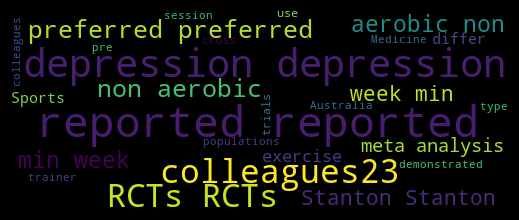

In [359]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

# list ->string
# keywords = non_person_keywords[:20]
# my_string = ' '.join(non_person_keywords[:20])

# summary 应该是一个字符串，包含了所有要显示在词云中的文本
# 创建 WordCloud 对象
wordcloud = WordCloud(
                width = 500, height = 200, 
                background_color ='black', 
                # stopwords = stopwords, 
                min_font_size = 10
            ).generate(summary)  # <wordcloud.wordcloud.WordCloud at 0x1673575d0> 是一个对象


# 使用 matplotlib 显示词云
plt.figure(figsize = (5, 5), facecolor = 'k', edgecolor = 'k' )  # plt.figure(figsize=(75, 50), facecolor=None)
plt.imshow(wordcloud)  # plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.tight_layout(pad=0)

# 显示图形
plt.show()



### Evaluate - Rouge Score

In [70]:
# from rouge_score import rouge_scorer

# # 定义文件路径

# text_path = "./test_pubmed12_abstract.txt"

# original_abstract=""

# # 打开文件，读取内容
# with open(text_path, 'r', encoding='utf-8') as file:
#     original_abstract = file.read()

# # 现在original_abstract变量包含了文本文件的内容
# # print(original_abstract)


# scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)
# scores = scorer.score('original_abstract', 't5_large_summary')
# print(scores)




from rouge_score import rouge_scorer

# 定义文件路径

text_path = "./test_pubmed12_abstract.txt"

original_abstract=""

# 打开文件，读取内容
with open(text_path, 'r', encoding='utf-8') as file:
    original_abstract = file.read()

# 现在original_abstract变量包含了文本文件的内容
# print(original_abstract)

def rouge_score(original_abstract, trained_abstract):
    # 计算ROUGE分数
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    scores = scorer.score(original_abstract, trained_abstract)

    # 输出ROUGE分数
    print("ROUGE-1:", scores['rouge1'].precision, scores['rouge1'].recall, scores['rouge1'].fmeasure)
    print("ROUGE-2:", scores['rouge2'].precision, scores['rouge2'].recall, scores['rouge2'].fmeasure)
    print("ROUGE-L:", scores['rougeL'].precision, scores['rougeL'].recall, scores['rougeL'].fmeasure)




rouge_score(original_abstract, t5_large_summary)
rouge_score(original_abstract, bart_summary)
rouge_score(original_abstract, gensim_summaries)




ROUGE-1: 0.9791666666666666 0.31125827814569534 0.4723618090452261
ROUGE-2: 0.9361702127659575 0.29333333333333333 0.44670050761421315
ROUGE-L: 0.9791666666666666 0.31125827814569534 0.4723618090452261
ROUGE-1: 0.9259259259259259 0.33112582781456956 0.4878048780487805
ROUGE-2: 0.7924528301886793 0.28 0.4137931034482759
ROUGE-L: 0.8703703703703703 0.31125827814569534 0.4585365853658536
ROUGE-1: 0.09025270758122744 0.16556291390728478 0.11682242990654207
ROUGE-2: 0.0036231884057971015 0.006666666666666667 0.004694835680751174
ROUGE-L: 0.039711191335740074 0.0728476821192053 0.05140186915887851


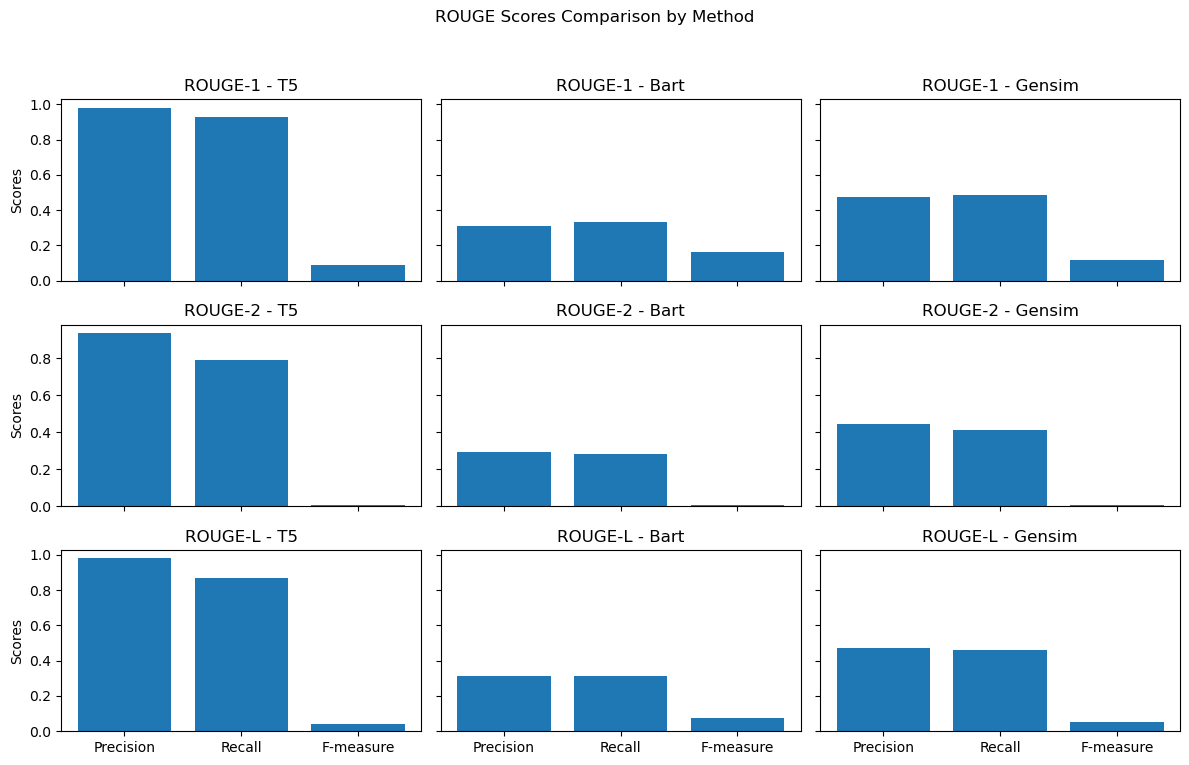

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# 假设你有三个方法的ROUGE分数数据，每个方法包含ROUGE-1、ROUGE-2和ROUGE-L的数据
methods = ['T5', 'Bart', 'Gensim']

rouge_metrics = ['ROUGE-1', 'ROUGE-2', 'ROUGE-L']
precision_scores = np.array([[0.9791666666666666, 0.31125827814569534, 0.4723618090452261],
                             [0.9361702127659575, 0.29333333333333333, 0.44670050761421315],
                             [0.9791666666666666, 0.31125827814569534, 0.4723618090452261]])

recall_scores = np.array([[0.9259259259259259, 0.33112582781456956, 0.4878048780487805],
                             [0.7924528301886793, 0.28, 0.4137931034482759],
                             [0.8703703703703703, 0.31125827814569534, 0.4585365853658536]])

fmeasure_scores = np.array([[0.09025270758122744, 0.16556291390728478, 0.11682242990654207],
                             [0.0036231884057971015, 0.006666666666666667, 0.004694835680751174],
                             [0.039711191335740074, 0.0728476821192053, 0.05140186915887851]])

# 创建一个子图的排列
num_rows = len(rouge_metrics)
num_cols = len(methods)

# 设置子图的位置
fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 8), sharex='col', sharey='row')

# 遍历每个ROUGE指标和方法，创建柱状图
for i in range(num_rows):
    for j in range(num_cols):
        ax = axs[i, j]
        ax.bar(range(len(methods)), [precision_scores[i, j], recall_scores[i, j], fmeasure_scores[i, j]])
        ax.set_title(f'{rouge_metrics[i]} - {methods[j]}')
        ax.set_xticks(range(len(methods)))
        ax.set_xticklabels(['Precision', 'Recall', 'F-measure'])
        if j == 0:
            ax.set_ylabel('Scores')

# 设置整体标题
plt.suptitle('ROUGE Scores Comparison by Method')

# 调整子图之间的间距
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# 显示图形
plt.show()


<BarContainer object of 3 artists>

<BarContainer object of 3 artists>

<BarContainer object of 3 artists>

Text(0.5, 0, 'ROUGE Metrics')

([<matplotlib.axis.XTick at 0x178b1f190>,
 [Text(0.3, 0, 'ROUGE-1'), Text(1.3, 0, 'ROUGE-2'), Text(2.3, 0, 'ROUGE-L')])

Text(0, 0.5, 'Scores')

Text(0.5, 1.0, 'ROUGE Scores Comparison')

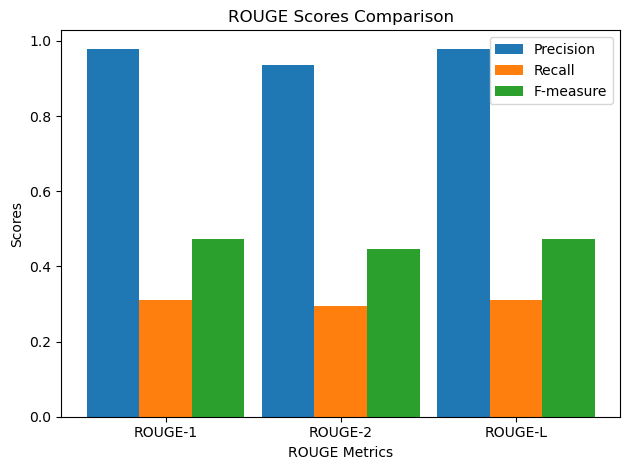

In [71]:
import matplotlib.pyplot as plt

# 示例ROUGE分数
rouge1_precision = 0.9791666666666666
rouge1_recall = 0.31125827814569534
rouge1_fmeasure = 0.4723618090452261

rouge2_precision = 0.9361702127659575
rouge2_recall = 0.29333333333333333
rouge2_fmeasure = 0.44670050761421315

rougeL_precision = 0.9791666666666666
rougeL_recall = 0.31125827814569534
rougeL_fmeasure = 0.4723618090452261

# ROUGE指标名称
labels = ['ROUGE-1', 'ROUGE-2', 'ROUGE-L']

# ROUGE分数数值
precision_scores = [rouge1_precision, rouge2_precision, rougeL_precision]
recall_scores = [rouge1_recall, rouge2_recall, rougeL_recall]
fmeasure_scores = [rouge1_fmeasure, rouge2_fmeasure, rougeL_fmeasure]

# 柱状图宽度
width = 0.3

# 设置子图的位置
x = range(len(labels))
fig, ax = plt.subplots()

# 绘制柱状图
plt.bar(x, precision_scores, width, label='Precision')
plt.bar([i + width for i in x], recall_scores, width, label='Recall')
plt.bar([i + 2 * width for i in x], fmeasure_scores, width, label='F-measure')

# 设置x轴标签
plt.xlabel('ROUGE Metrics')
plt.xticks([i + width for i in x], labels)

# 设置y轴标签
plt.ylabel('Scores')

# 添加图例
plt.legend()

# 添加标题
plt.title('ROUGE Scores Comparison')

# 显示图形
plt.tight_layout()
plt.show()


### Evaluate - BERTScore

In [49]:
from bert_score import score

def calculate_bert_scores(candidates, references):
    P, R, F1 = score(candidates, references, lang="en", verbose=True)
    return P.mean().item(), R.mean().item(), F1.mean().item()

# 确保 t5_large_summary, bert_summaries, gensim_summaries, 和 original_abstract 都是列表，并且它们的长度相同
# 如果是字符串，用[]转成列表形式传参
P, R, F1 = calculate_bert_scores([t5_large_summary], [original_abstract])
print(f"T5-Large BERTScores - Precision: {P}, Recall: {R}, F1-Score: {F1}")

P, R, F1 = calculate_bert_scores([bart_summary], [original_abstract])
print(f"BERT BERTScores - Precision: {P}, Recall: {R}, F1-Score: {F1}")

P, R, F1 = calculate_bert_scores([gensim_summaries], [original_abstract])
print(f"Gensim BERTScores - Precision: {P}, Recall: {R}, F1-Score: {F1}")


model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.97 seconds, 1.03 sentences/sec
T5-Large BERTScores - Precision: 0.9620826244354248, Recall: 0.8713266253471375, F1-Score: 0.9144583344459534


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.53 seconds, 1.89 sentences/sec
BERT BERTScores - Precision: 0.9362745881080627, Recall: 0.8691570162773132, F1-Score: 0.9014682769775391


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 1.13 seconds, 0.89 sentences/sec
Gensim BERTScores - Precision: 0.7129749655723572, Recall: 0.7981893420219421, F1-Score: 0.7531794905662537


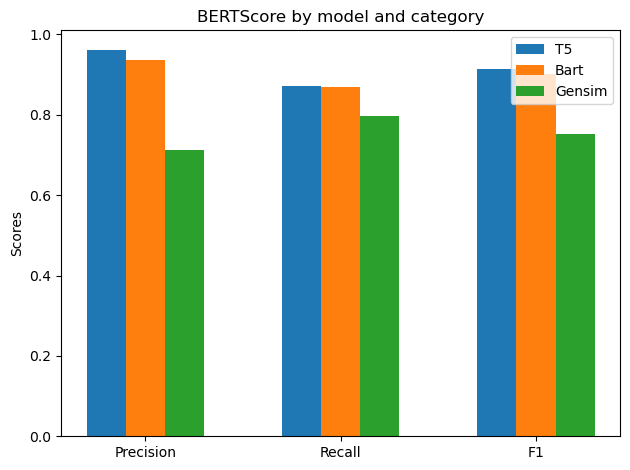

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# 假设你已经有了每个模型的BERTScore的P, R, F1值
t5_scores = {'Precision': 0.9620826244354248, 'Recall': 0.8713266253471375, 'F1': 0.9144583344459534}
bert_scores = {'Precision': 0.9362745881080627, 'Recall': 0.8691570162773132, 'F1': 0.9014682769775391}
gensim_scores = {'Precision': 0.7129749655723572, 'Recall': 0.7981893420219421, 'F1': 0.7531794905662537}

labels = list(t5_scores.keys())
t5_vals = list(t5_scores.values())
bert_vals = list(bert_scores.values())
gensim_vals = list(gensim_scores.values())

x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, t5_vals, width, label='T5')
rects2 = ax.bar(x, bert_vals, width, label='Bart')
rects3 = ax.bar(x + width, gensim_vals, width, label='Gensim')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('BERTScore by model and category')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Function to attach a text label above each bar, displaying its height.
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

# autolabel(rects1)
# autolabel(rects2)
# autolabel(rects3)

fig.tight_layout()

plt.show()


### Evaluate - confusion matrix

In [58]:
# 混淆矩阵

# 定义阈值
bertscore_threshold = 0.8

# 计算混淆矩阵
def calculate_confusion_matrix(summaries, references, threshold):
    _, _, F1 = score(summaries, references, lang="en", verbose=True)
    correct = (F1 > threshold).sum().item()
    incorrect = len(F1) - correct
    return correct, incorrect

correct, incorrect = calculate_confusion_matrix([t5_large_summary], [original_abstract], bertscore_threshold)
print(f"T5-Large BERTScores - correct: {correct}, incorrect: {incorrect}")

correct, incorrect = calculate_confusion_matrix([bart_summary], [original_abstract], bertscore_threshold)
print(f"BERT BERTScores - correct: {correct}, incorrect: {incorrect}")

correct, incorrect = calculate_confusion_matrix([gensim_summaries], [original_abstract], bertscore_threshold)
print(f"Gensim BERTScores - correct: {correct}, incorrect: {incorrect}")



Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.50 seconds, 2.00 sentences/sec
T5-Large BERTScores - correct: 1, incorrect: 0


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.40 seconds, 2.47 sentences/sec
BERT BERTScores - correct: 1, incorrect: 0


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.93 seconds, 1.07 sentences/sec
Gensim BERTScores - correct: 0, incorrect: 1


<Axes: >

Text(0.5, 1.0, 'Summary Quality Confusion Matrix')

Text(0.5, 23.52222222222222, 'Summary Quality')

Text(50.722222222222214, 0.5, 'Models')

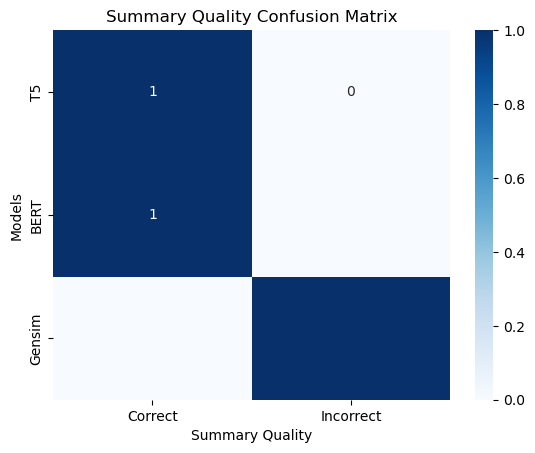

In [66]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 这里是你的数据，每个元素是一个二元组 (correct, incorrect)
t5_confusion_matrix = (1, 0)  # 例如，T5 模型正确:1，错误:0
bert_confusion_matrix = (1, 0)  # 你需要用实际的数据替换这里
gensim_confusion_matrix = (0, 1)  # 你需要用实际的数据替换这里

# 将这些数据转换成 numpy 数组，以便绘图
matrix_data = np.array([t5_confusion_matrix, bert_confusion_matrix, gensim_confusion_matrix])
models = ['T5', 'BERT', 'Gensim']
categories = ['Correct', 'Incorrect']

# 创建热力图
sns.heatmap(matrix_data, annot=True, fmt="d", cmap="Blues", xticklabels=categories, yticklabels=models)

# 添加标题和轴标签
plt.title('Summary Quality Confusion Matrix')
plt.xlabel('Summary Quality')
plt.ylabel('Models')
plt.show()


In [78]:
# 条形图
import matplotlib.pyplot as plt

# 假设你已经计算了一些评估指标
t5_scores = {'Rouge-1': 0.5, 'Rouge-2': 0.4, 'BERTScore': 0.7129749655723572}
bert_scores = {'Rouge-1': 0.6, 'Rouge-2': 0.45, 'BERTScore': bert_bert_scores[2]}
gensim_scores = {'Rouge-1': 0.55, 'Rouge-2': 0.35, 'BERTScore': gensim_bert_scores[2]}

labels = list(t5_scores.keys())
t5_vals = list(t5_scores.values())
bert_vals = list(bert_scores.values())
gensim_vals = list(gensim_scores.values())

x = range(len(labels))

plt.bar(x, t5_vals, width=0.2, label='T5')
plt.bar(x, bert_vals, width=0.2, label='BERT', bottom=t5_vals)
plt.bar(x, gensim_vals, width=0.2, label='Gensim', bottom=[i+j for i,j in zip(t5_vals, bert_vals)])

plt.xticks(x, labels)
plt.ylabel("Scores")
plt.legend()
plt.show()


NameError: name 'bert_bert_scores' is not defined

### Evaluate - BLEU

In [82]:
import nltk

def bleu_score(original_abstract, trained_data):

    # 使用nltk计算BLEU分数
    reference_tokenized = nltk.word_tokenize(original_abstract)
    system_summary_tokenized = nltk.word_tokenize(trained_data)
    bleu_score = nltk.translate.bleu_score.sentence_bleu([reference_tokenized], system_summary_tokenized)
    
    # 输出BLEU分数
    print("BLEU Score:", bleu_score)

bleu_score(original_abstract, t5_large_summary)
bleu_score(original_abstract, bart_summary)
bleu_score(original_abstract, gensim_summaries)



BLEU Score: 0.09063995337445475
BLEU Score: 0.14306037729619697
BLEU Score: 2.1622140574945903e-155


In [5]:
# import torch # BertModel requires the PyTorch library 
# from transformers import BertModel, BertTokenizer

# # 加载分词器和模型
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# model = BertModel.from_pretrained('bert-base-uncased')


# # 对文本进行编码
# inputs = tokenizer("Hello, my dog is cute", return_tensors="pt")

# # 通过模型获取输出
# outputs = model(**inputs)

# # 输出包含了多层的信息，通常我们使用最后一层的隐藏状态
# last_hidden_states = outputs.last_hidden_state
# last_hidden_states
# # 现在你可以使用tokenizer来处理你的文本，然后使用model来获取文本的嵌入表示


tensor([[[-0.1144,  0.1937,  0.1250,  ..., -0.3827,  0.2107,  0.5407],
         [ 0.5308,  0.3207,  0.3665,  ..., -0.0036,  0.7579,  0.0388],
         [-0.4877,  0.8849,  0.4256,  ..., -0.6976,  0.4458,  0.1231],
         ...,
         [-0.7003, -0.1815,  0.3297,  ..., -0.4838,  0.0680,  0.8901],
         [-1.0355, -0.2567, -0.0317,  ...,  0.3197,  0.3999,  0.1795],
         [ 0.6080,  0.2610, -0.3131,  ...,  0.0311, -0.6283, -0.1994]]],
       grad_fn=<NativeLayerNormBackward0>)

In [ ]:
pip install bert-for-tf2

In [ ]:
data source: https://www.kaggle.com/datasets/sebastienverpile/consumercomplaintsdata/data

## 5. Extract Heading and Blocked Content

In [38]:
5. How to extract text under specific headings from a pdf?

[]


In [24]:
from transformers import BertModel, BertTokenizer
import torch
from torch import nn

class NERModel(nn.Module):
    def __init__(self, num_labels):
        super(NERModel, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask, token_type_ids):
        outputs = self.bert(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        sequence_output = outputs.last_hidden_state
        logits = self.classifier(sequence_output)
        return logits


# 加载模型和分词器
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = NERModel(num_labels=10)  # 假设有10个实体标签

text = methodology_text
inputs = tokenizer(text, return_tensors="pt", max_length=512, truncation=True)

# 获取模型预测的实体标签
# logits = model(**inputs)
# 确保模型预测时使用了所有的BERT输入
logits = model(input_ids=inputs['input_ids'], attention_mask=inputs['attention_mask'], token_type_ids=inputs['token_type_ids'])
predicted_label_ids = torch.argmax(logits, dim=2)

# # 将标签ID转换为标签名称（这里需要实体标签的映射）
# label_map = {0: 'O', 1: 'B-METHOD', 2: 'I-METHOD'}  # 示例标签映射
# predicted_labels = [label_map[label_id] for label_id in predicted_label_ids[0]]
# 假设我们的label_map是0到9的标签
label_map = {i: f'LABEL_{i}' for i in range(10)}  # 示例标签映射
predicted_labels = [label_map.get(label_id.item(), 'UNKNOWN') for label_id in predicted_label_ids[0]]
predicted_labels

['LABEL_4',
 'LABEL_4',
 'LABEL_9',
 'LABEL_0',
 'LABEL_0',
 'LABEL_6',
 'LABEL_9',
 'LABEL_2',
 'LABEL_0',
 'LABEL_0',
 'LABEL_0',
 'LABEL_2',
 'LABEL_2',
 'LABEL_9',
 'LABEL_8',
 'LABEL_1',
 'LABEL_0',
 'LABEL_0',
 'LABEL_8',
 'LABEL_0',
 'LABEL_8',
 'LABEL_1',
 'LABEL_8',
 'LABEL_8',
 'LABEL_8',
 'LABEL_7',
 'LABEL_8',
 'LABEL_8',
 'LABEL_8',
 'LABEL_8',
 'LABEL_0',
 'LABEL_4',
 'LABEL_9',
 'LABEL_2',
 'LABEL_6',
 'LABEL_1',
 'LABEL_8',
 'LABEL_6',
 'LABEL_6',
 'LABEL_4',
 'LABEL_6',
 'LABEL_6',
 'LABEL_6',
 'LABEL_6',
 'LABEL_2',
 'LABEL_0',
 'LABEL_6',
 'LABEL_6',
 'LABEL_9',
 'LABEL_0',
 'LABEL_8',
 'LABEL_9',
 'LABEL_0',
 'LABEL_6',
 'LABEL_3',
 'LABEL_0',
 'LABEL_6',
 'LABEL_2',
 'LABEL_6',
 'LABEL_1',
 'LABEL_0',
 'LABEL_6',
 'LABEL_6',
 'LABEL_3',
 'LABEL_3',
 'LABEL_3',
 'LABEL_9',
 'LABEL_6',
 'LABEL_2',
 'LABEL_3',
 'LABEL_2',
 'LABEL_2',
 'LABEL_0',
 'LABEL_0',
 'LABEL_0',
 'LABEL_6',
 'LABEL_6',
 'LABEL_1',
 'LABEL_6',
 'LABEL_6',
 'LABEL_2',
 'LABEL_2',
 'LABEL_8',
 'LA

In [22]:
import fitz  # PyMuPDF

# 定义提取PDF目录的函数
def extract_toc(pdf_path):
    # 打开PDF文件
    doc = fitz.open(pdf_path)
    toc = doc.get_toc()  # 获取目录结构
    doc.close()  # 关闭文档
    return toc

# 指定PDF文件路径
pdf_path = "../test_paper2.pdf" # 替换为你的PDF文件路径

# 提取目录结构
table_of_contents = extract_toc(pdf_path)

# 打印目录结构
for entry in table_of_contents:
    level, title, page = entry
    print(f"{'  ' * (level - 1)}{title} - 第{page}页")


Exercise and the treatment of depression: A review of the exercise program variables - 第1页
  1 Introduction - 第1页
  2 Methods - 第2页
  3 Results - 第3页
  4 Discussion - 第3页
  5 Recommendations from this review - 第5页
  6 Comparison with healthy and clinical populations - 第5页
  7 Limitations - 第6页
  8 Future recommendations - 第6页
  9 Summary - 第6页
  References - 第6页


In [80]:
import fitz  # PyMuPDF

def extract_text_with_format(pdf_path, granularity_flags):
    doc = fitz.open(pdf_path)
    print(doc.metadata)
    print(doc.get_toc())
    
    formatted_text = []

    for page_num in range(len(doc)):
        page = doc.load_page(page_num)
        blocks = page.get_text("dict")["blocks"]
        for b in blocks:  # 遍历页面上的每一个文本块
            if 'lines' in b:  # 确保文本块中包含'lines'
                for l in b["lines"]:  # 遍历文本块中的每一行
                    for s in l["spans"]:  # 遍历行中的每个文本跨度
                        if granularity_flags['size'] and s['size'] < 12:
                            # 假设小于12pt的文字可能是下标
                            text_element = ('subscript', s['text'])
                        elif granularity_flags['size'] and s['size'] > 13:
                            # 假设大于13pt的文字可能是标题
                            text_element = ('header', s['text'])
                        else:
                            # 其他的都假设是普通段落文本
                            text_element = ('paragraph', s['text'])
                        formatted_text.append(text_element)
    
    doc.close()
    return formatted_text

# 配置我们希望识别的文本属性
granularity_flags = {
    "size": True,   # 根据字体大小
    "font": False,  # 根据字体样式
    "color": False, # 根据字体颜色
    "flags": False, # 根据文本属性标志，如加粗或斜体
}

# 指定PDF文件路径
pdf_path = "../test_paper2.pdf" # 替换为你的PDF文件路径

# 提取并尝试识别文本格式
formatted_text = extract_text_with_format(pdf_path, granularity_flags)

# 打印出前几个识别的文本格式元素，示例：(类型, 文本)
for text_element in formatted_text[:10]:
    print(text_element)


{'format': 'PDF 1.7', 'title': 'Exercise and the treatment of depression: A review of the exercise program variables', 'author': 'Robert Stanton', 'subject': 'Journal of Science and Medicine in Sport, 17 (2014) 177-182. doi:10.1016/j.jsams.2013.03.010', 'keywords': '', 'creator': 'Elsevier', 'producer': 'Acrobat Distiller 9.0.0 (Windows)', 'creationDate': 'D:20140131131119Z', 'modDate': "D:20140223022850+05'30'", 'trapped': '', 'encryption': None}
[[1, 'Exercise and the treatment of depression: A review of the exercise program variables', 1], [2, '1 Introduction', 1], [2, '2 Methods', 2], [2, '3 Results', 3], [2, '4 Discussion', 3], [2, '5 Recommendations from this review', 5], [2, '6 Comparison with healthy and clinical populations', 5], [2, '7 Limitations', 6], [2, '8 Future recommendations', 6], [2, '9 Summary', 6], [2, 'References', 6]]
('subscript', 'Journal')
('subscript', ' ')
('subscript', 'of')
('subscript', ' ')
('subscript', 'Science')
('subscript', ' ')
('subscript', 'and')

In [117]:
# 目录结构：
# toc.append([1, 'Exercise and the treatment of depression: A review of the exercise program variables', 1])
# [
#     [1, 'Exercise and the treatment of depression: A review of the exercise program variables', 1], 
#     [2, '1 Introduction', 1], 
#     [2, '2 Methods', 2], 
#     [2, '3 Results', 3], 
#     [2, '4 Discussion', 3], 
#     [2, '5 Recommendations from this review', 5], 
#     [2, '6 Comparison with healthy and clinical populations', 5], 
#     [2, '7 Limitations', 6], 
#     [2, '8 Future recommendations', 6], 
#     [2, '9 Summary', 6], 
#     [2, 'References', 6]
# ]
# [章节级别（Level）,章节标题（Title）,章节开始的页面]


import fitz  # PyMuPDF

# 打开PDF文件
doc = fitz.open("../test_paper2.pdf")





# 获取Page 页面对象的属性和方法
page = doc.load_page(1)  # 默认加载第一页
print("page 对象:", page) # page 对象: page 1 of ../test_paper2.pdf

# 1、获取Page 页面的链接、批注或表单字段
# links = page.get_links()
# for link in links:
#     print("链接:", link)
 
# annots = page.annots()
# for annot in annots:
#     # 涉及Annot 对象
#     print("批注:", annot)
 
# widgets = page.widgets()
# for widget in widgets:
#     # 涉及表单字段
#     print("表单字段:", widget)


# 3、Page 获取文本\图像\其他信息
# 温馨提示:涉及TextPage 常量类型定义
# text = page.get_text("text")
# print("指定页面文本内容:", text)

# 4、Page 文本检索
search = page.search_for("Methods")
print("打印检索文本的位置:", search)


# 获取目录
toc = doc.get_toc()


# 定义可能的变形
method_variants = {'method', 'methods', 'methodology', 'methodologies', 'research methods'}


matching_entry = None
for i, (level, title, page_num) in enumerate(toc):
    if any(word.lower() in title.lower() for word in method_variants): # 将标题转换为小写，并与变形集合进行比较,any一个为True就为True
        matching_entry = (level, title, page_num)
        break

# 检查是否找到匹配条目
if matching_entry is None: # matching_entry == None:？？
    print("未在目录中找到指定的章节标题。")
else:
    level, title, page_num = matching_entry
    page = doc.load_page(page_num - 1)  # 页面编号基于1，所以减1
    # 寻找标题在页面上的边界框
    text_bbox = None
    for word in page.get_text("words"):  # 获取页面上的每个词
        if title.lower() in word[4].lower():  # word[4]是词的文本
            # word[:4]包含边界框的坐标
            if text_bbox is None:
                text_bbox = fitz.Rect(word[:4])
            else:
                text_bbox = text_bbox | fitz.Rect(word[:4])  # 合并边界框
    # 输出匹配的章节标题和位置信息
    print(f"匹配的目录条目: {title}")
    print(f"位置信息 (边界框): {text_bbox}")
    # 如果找到了标题的边界框
    if text_bbox:
        # 假设章节文本从标题下方开始
        text_area = fitz.Rect(text_bbox.x0, text_bbox.y1, text_bbox.x1, page.rect.y1)
        section_text = page.get_textbox(text_area)
        print(section_text)
    else:
        print("未在页面上找到章节标题。")


#     level, title, page_num = matching_entry
#     page = doc.load_page(page_num - 1)  # Page numbers are 1-based, so subtract 1

#     # Iterate through the words on the page to find the bounding box of the title
#     text_bbox = None
#     for word in page.get_text_words():
#         if title.lower() in word[4].lower():
#             if text_bbox is None:
#                 text_bbox = fitz.Rect(word[:4])
#             else:
#                 text_bbox = text_bbox + fitz.Rect(word[:4])
    
#     print(f"Matching TOC Entry: {title}")
#     print(f"Position Information (Rect): {text_bbox}")




    
# 关闭文档
doc.close()







page 对象: page 1 of ../test_paper2.pdf
打印检索文本的位置: [Rect(77.59620666503906, 96.395263671875, 111.08655548095703, 106.25428009033203), Rect(313.3341979980469, 325.2271423339844, 348.2352294921875, 335.173828125)]
匹配的目录条目: 2 Methods
位置信息 (边界框): None
未在页面上找到章节标题。


---

## 6. Extract Methodology

 ### BERT - Methodology - bert-base-uncased

In [17]:
# ********** 理解文档结构 - 需要识别文档的逻辑结构（如标题、子标题、段落）**********

import re
import spacy
from collections import Counter


# ********** 关键词识别：使用基本的字符串方法或正则表达式来搜索关键词。 re **********
text = raw_text
keywords = ["Methods", "Research Methods", "Methodology"]
for keyword in keywords:
    if re.search(keyword, text):
        print(f"发现关键词: {keyword}")


# 正则表达式：使用正则表达式来定位方法论部分的开始和结束。
methodology_section = re.search(r'(Methods)\s*[\s\S]*?(Results)', text)
if methodology_section:
    methodology_text = methodology_section.group()
methodology_text

# # 加载Spacy模型
# nlp = spacy.load("en_core_web_sm")

# # 假设你已经有了方法论部分的文本
# methodology_text = """这里是你的方法论部分的文本..."""

# # 对文本进行处理
# doc = nlp(methodology_text)

# # 初始化一个计数器来存储方法
# methods = Counter()

# # 遍历文档中的每个词
# for token in doc:
#     # 选择名词和专有名词
#     if token.pos_ in ['NOUN', 'PROPN']:
#         methods[token.lemma_] += 1

# # 输出最常见的术语
# print(methods.most_common(10))





methodology_text = "Our methodology is similar to that of Perraton and colleagues. Our review initially considered all RCTs published since 1960 ful- filling the following criteria: 1. Population: All adults aged 18–65 years with a diagnosis of depression as defined by the Diagnostic and Statistical Manual of Mental Disorders, Fourth Edition (DSM IV), International Statistical Classification of Diseases and Related Health Problems 10th Revision (ICD-10) criteria or a validated depression scale. 2. Intervention: Aerobic or resistance training program, or a combination of both, of any duration. 3. Comparison group: Any other intervention including pharmacotherapy, education, psychotherapy, other exercise program, or no intervention including wait list controls. 4. Outcome measures: Validated depression rating scales."


from transformers import BertModel, BertTokenizer
import torch

def del_space(text):
    text1 = text.replace('\n', ' ').strip() 
    text2 = text1.replace(" .", ".")  # 替换句号前面的空格 "depressive episode ."
    text3 = re.sub(r'\s+', ' ', text2)  # 使用正则表达式替换多个连续空格为单个空格
    return text3
    
# 加载分词器和模型
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# text = "考虑了所有RCTs，验证了抑郁症，包括等待，验证了抑郁症状。"

# 对文本进行编码
inputs = tokenizer(methodology_text, return_tensors="pt", max_length=512, truncation=True)

# 获取BERT模型的输出
outputs = model(**inputs)

# outputs.last_hidden_state有模型最后一层的隐藏状态
# 这些隐藏状态可以用于提取高层次的语义信息
# 你可以在此基础上构建实体提取或文本分类任务
# 例如，你可以结合实体识别模型来识别和提取方法论中提到的方法






发现关键词: Methods


'Methods:\n Studies\n were  analyzed\n for  exercise\n frequency,\n intensity,\n session\n duration,\n exercise\n type,  exercise\nmode,\n intervention\n duration,\n delivery\n of  exercise,\n level\n and  quality  of  supervision\n and  compliance.\n Study\nquality\n was  assessed\n using  the  PEDro\n scale.\nResults'

## 7. Visualize of Frontend

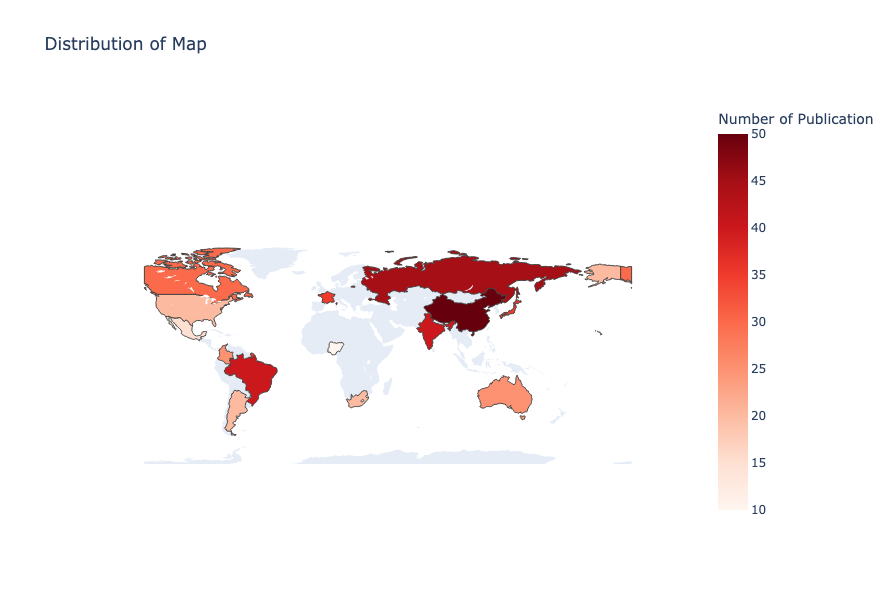

In [26]:
import plotly.graph_objs as go
import pandas as pd

# 创建一个包含国家代码和随机数值的 DataFrame
df = pd.DataFrame({
    'iso_alpha': ['USA', 'CAN', 'MEX', 'BRA', 'ARG', 'COL', 'GER', 'FRA', 'RUS', 'CHN', 'IND', 'AUS', 'JPN', 'ZAF', 'NGA'],
    'value': [20, 30, 15, 40, 20, 25, 30, 35, 45, 50, 40, 25, 35, 20, 10]  # 随机值
})

fig = go.Figure(data=go.Choropleth(
    locations=df['iso_alpha'],  # Spatial coordinates
    z=df['value'].astype(float),  # Data to be color-coded
    text=df['iso_alpha'],  # Text to display on hover
    colorscale='Reds',
    colorbar_title="Number of Publication",
))

fig.update_layout(
    title_text='Distribution of Map',
    geo=dict(
        showframe=False,
        showcoastlines=False,
        projection_type='equirectangular'
    ),
    width=900,
    height=600
)

fig.show()


### Bar - Total Number of Literature Categories

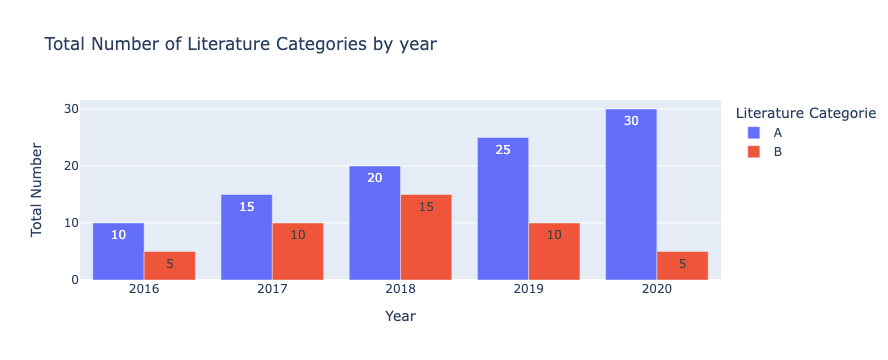

In [30]:
import pandas as pd
import plotly.graph_objs as go

# 假设的数据集
data = {
    'Year': ['2016', '2017', '2018', '2019', '2020', '2016', '2017', '2018', '2019', '2020'],
    'Category': ['A', 'A', 'A', 'A', 'A', 'B', 'B', 'B', 'B', 'B'],
    'Count': [10, 15, 20, 25, 30, 5, 10, 15, 10, 5]
}

df = pd.DataFrame(data)

# 按照年份和类别对数据进行分组，计算总数
df_grouped = df.groupby(['Year', 'Category']).sum().reset_index()

# 创建一个条形图
fig = go.Figure()

# 对于每个类别，添加一个条形图迹线
for category in df_grouped['Category'].unique():
    df_category = df_grouped[df_grouped['Category'] == category]
    fig.add_trace(go.Bar(
        x=df_category['Year'],
        y=df_category['Count'],
        name=category,
        text=df_category['Count'],
        textposition='auto',
    ))

# 更新布局以添加标题和使图例可点击
fig.update_layout(
    title_text='Total Number of Literature Categories by year', # 年度文献类别总数
    xaxis=dict(title='Year'),
    yaxis=dict(title='Total Number'), # 文献总数
    barmode='group',
    legend_title_text='Literature Categories'  # 文献类别
)

# 显示图表
fig.show()


### line - Total Number of Literature Categories

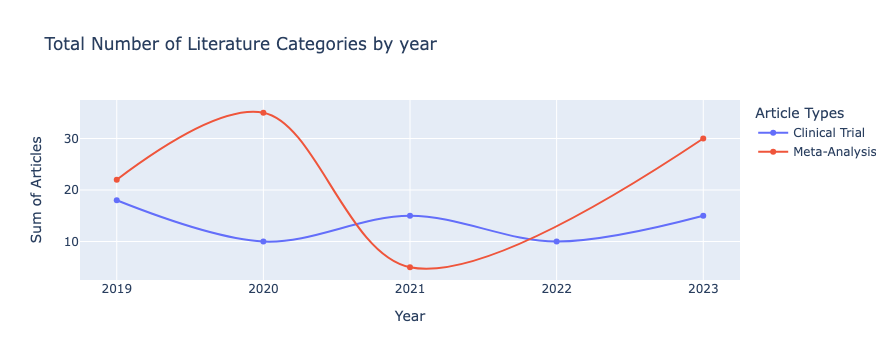

In [15]:
# https://blog.csdn.net/weixin_56659172/article/details/126098284?ops_request_misc=&request_id=&biz_id=102&utm_term=fig%20=%20go.Figure()%20%E6%AF%8F%E6%AC%A1%E5%88%9B%E5%BB%BA%E4%B8%80%E4%B8%AA%E5%9B%BE&utm_medium=distribute.pc_search_result.none-task-blog-2~all~sobaiduweb~default-0-126098284.142^v99^control&spm=1018.2226.3001.4187
import pandas as pd
import plotly.graph_objs as go

# 假设的数据集
data = {
    'Year': ['2020', '2019', '2020', '2021', '2019', '2023', '2019', '2020', '2021', '2022', '2023'],
    'Category': ['Meta-Analysis', 'Meta-Analysis', 'Meta-Analysis', 'Meta-Analysis', 'Meta-Analysis', 'Meta-Analysis', 'Clinical Trial', 'Clinical Trial', 'Clinical Trial', 'Clinical Trial', 'Clinical Trial'],
    'Count': [20, 10, 15, 5, 12, 30, 18, 10, 15, 10, 15]
}

df = pd.DataFrame(data)

# 按照年份和类别对数据进行分组，计算总数
df_grouped = df.groupby(['Year', 'Category']).sum().reset_index()

# 创建一个折线图
fig = go.Figure()

# 对于每个类别，添加一个折线图迹线
for category in df_grouped['Category'].unique():
    df_category = df_grouped[df_grouped['Category'] == category]
    fig.add_trace(go.Scatter(
        x=df_category['Year'],
        y=df_category['Count'],
        mode='lines+markers',
        name=category,
        line=dict(shape='spline')  # 设置为平滑曲线
    ))

# 更新布局以添加标题和使图例可点击
fig.update_layout(
    title_text='Total Number of Literature Categories by year',  # 年度文献类别总数
    xaxis=dict(title='Year'),
    yaxis=dict(title='Sum of Articles'),
    legend_title_text='Article Types'
)

# 显示图表
fig.show()
